In [118]:
%matplotlib inline

In [119]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta

In [120]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [121]:
import seaborn as sns

In [122]:
import numpy as np
import pandas as pd

In [123]:
nino = "3.4"

In [124]:
url = "http://www.bom.gov.au/climate/enso/nino_%s.txt" % (nino)

In [125]:
r = requests.get(url)

if r.status_code != 200: 
    print(f"something went wrong with accessing the URL {url}")

else: 

    nino_index = pd.read_table(BytesIO(r.content), sep=',', header=None, index_col=1, parse_dates=True, names=['iDate','SST'])

In [126]:
nino_index.tail()

,iDate,SST
2020-03-15,20200309,0.36
2020-03-22,20200316,0.63
2020-03-29,20200323,0.50
2020-04-05,20200330,0.50
2020-04-12,20200406,0.54


In [127]:
today = datetime.utcnow() - timedelta(15)

In [128]:
nino_index = nino_index.loc['2019-01':'2020-03',:]

In [129]:
nino_index = nino_index.resample('1M').mean()

In [130]:
dates = nino_index.index.to_pydatetime()

In [191]:
dates_str = [f"{x:%Y-%b}" for x in dates]

In [132]:
basis = np.arange(len(dates))

In [133]:
nino_values = nino_index.SST.values

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [134]:
enso_cat = pd.read_csv('../data/template_Pacific_RCC_ENSO_tracker.csv')

In [135]:
enso_cat

,YEAR,MONTH,NOAA,BoM,APCC,NIWA
0,2019,1,neutral,El_Nino_alert,neutral,El_Nino_watch
1,2019,2,El_Nino,El_Nino_watch,El_Nino,El_Nino_alert
2,2019,3,El_Nino,El_Nino_watch,El_Nino,El_Nino
3,2019,4,El_Nino,El_Nino_alert,El_Nino,El_Nino
4,2019,5,El_Nino,El_Nino_watch,El_Nino,El_Nino
5,2019,6,El_Nino,El_Nino_watch,El_Nino,El_Nino
6,2019,7,El_Nino,neutral,neutral,El_Nino
7,2019,8,neutral,neutral,neutral,neutral
8,2019,9,neutral,neutral,neutral,neutral
9,2019,10,neutral,neutral,neutral,neutral


In [136]:
cat_to_int = {} 

cat_to_int['La_Nina'] = -3
cat_to_int['La_Nina_alert'] = -2
cat_to_int['La_Nina_watch'] = -1
cat_to_int['neutral'] = 0
cat_to_int['El_Nino_watch'] = 1 
cat_to_int['El_Nino_alert'] = 2 
cat_to_int['El_Nino'] = 3

In [137]:
enso_cat_int = enso_cat.replace(cat_to_int)

In [138]:
enso_cat_int.loc[:,'date'] = np.NaN

In [139]:
enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)

In [140]:
enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1)

In [141]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [142]:
enso_cat_int.shape

(15, 4)

In [157]:
len(dates)

15

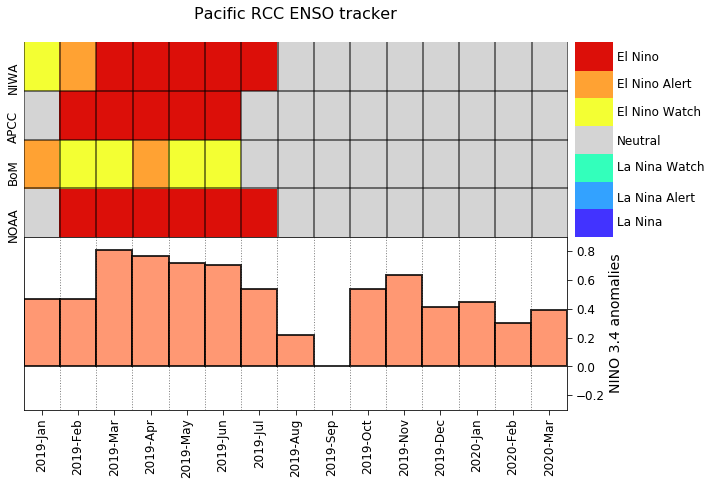

In [192]:
f = plt.figure(figsize=(10,6))

#  [left, bottom, width, height] 

# defines the axes 

ax0 = f.add_axes([0.1, 0.45, 0.9, 0.45])

ax0.set_title("Pacific RCC ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.05, 0.755, 0.4])

# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.5, 1.5, 2.5, 3.5]);

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,16)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,4)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)


# second set of axes: ENSO barplot


ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)


ax1.set_xlim([-0.5,len(dates) - 0.5])

ax1.set_ylim([-0.3, 0.9])

ax1.yaxis.tick_right()

ax1.set_ylabel('NINO 3.4 anomalies', fontsize=14)

ax1.yaxis.set_label_position("right")

# ax1.grid(ls=':')

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];


f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')